In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mat
import seaborn as sb
from sklearn import linear_model as lm
import math
# problem one:
#part a
#read the file 
state = pd.read_csv('statements.csv')
#convert to lowercase
state['text'] = state['text'].str.lower()
#remove punctuation 
state['text'] = state['text'].str.replace('[^\w\s]','', regex=True)
# remove stop words 
#open NLTK_English_stopwords.txt file 
NLTK = open('NLTK_English_stopwords.txt', 'r')
#read and split into list of words 
NLTK = NLTK.read().split('\n')
#remove the list of words from statements.csv
state['text'] = state['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (NLTK)]))
#consider only words with 4 or more letters
state['text'] = state['text'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 3]))
#statements file has been cleaned 
#the number of unique words
print(len(set(' '.join(state['text']).split())))
#the ten most commonw words 
print('10 most common words:\n', pd.Series(' '.join(state['text']).split()).value_counts()[:10])

2646
10 most common words:
 going      114
people     107
know        72
said        58
thats       48
country     47
want        45
like        43
think       42
world       40
dtype: int64


In [4]:
#problem two
#part a
def count_words_in_sentences(state, speaker):
    #counts number of occurance of word in sentences by president 
    sentences = state[state['speaker'] == speaker]['text'].str.split().reset_index(drop=True)
    count_of_word = pd.Series(np.concatenate(sentences)).value_counts()
    return pd.DataFrame({'word': count_of_word.index, f'{speaker}_count': count_of_word.values})
def count_sentences_with_word(state, speaker, word):
    #number of sentences containing given word 
    sentences = state[state['speaker'] == speaker]['text']
    return pd.DataFrame({f'{speaker}_sentence_count': sentences.str.contains(word).sum()}, index=[word])
def calculate_phi_coefficient(trump_count, obama_count, total_trump_sentences, total_obama_sentences):
    #calcualte the phi coefficient 
    a = trump_count
    b = obama_count
    c = total_trump_sentences - a
    d = total_obama_sentences - b
    return (a * d - b * c) / np.sqrt((a + b) * (c + d) * (a + c) * (b + d))
#number of occurances of each word 
count_of_word = pd.Series(' '.join(state['text']).split()).value_counts().reset_index()
count_of_word.columns = ['word', 'count']
#counts the ocuurrances of words spoken by each of the preseidents in the sentences 
obama_count_of_word = count_words_in_sentences(state, 'obama')
trump_count_of_word = count_words_in_sentences(state, 'trump')
#counts the number of sentences which contain wach word spoken by each of the presidents 
obama_sentence_counts = pd.concat([count_sentences_with_word(state, 'obama', word) for word in obama_count_of_word['word']])
trump_sentence_counts = pd.concat([count_sentences_with_word(state, 'trump', word) for word in trump_count_of_word['word']])
#merges the tables 
count_of_word = count_of_word.merge(obama_count_of_word, on='word', how='left')
count_of_word = count_of_word.merge(obama_sentence_counts, left_on='word', right_index=True)
count_of_word = count_of_word.merge(trump_count_of_word, on='word', how='left')
count_of_word = count_of_word.merge(trump_sentence_counts, left_on='word', right_index=True)
#replaces the NaN values with 0's
count_of_word = count_of_word.fillna(0)
#phi coeeffficient for each word 
total_sentences_obama = state[state['speaker'] == 'obama']['text'].count()
total_sentences_trump = state[state['speaker'] == 'trump']['text'].count()
count_of_word['phi'] = count_of_word.apply(lambda row: calculate_phi_coefficient(row['trump_count'], 
                                                          row['obama_count'], 
                                                          total_sentences_trump, total_sentences_obama), axis=1)
#ten words correlated with trump
trump_words = count_of_word.sort_values('phi', ascending=False)['word'][:10]
print('Ten words closely correlated with Donlad Trump :\n', trump_words)
#ten words correlated with obama
obama_words = count_of_word.sort_values('phi', ascending=True)['word'][:10]
print('Ten words closely correlated with Barack Obama:\n', obama_words)
#sjows the table
count_of_word

Ten words closely correlated with Donlad Trump :
 0         going
8         think
2          know
3          said
11        great
38         look
12       theyre
28       really
44    something
25        money
Name: word, dtype: object
Ten words closely correlated with Barack Obama:
 17         must
43        today
36        years
91     together
59        thank
101       stand
47         care
33         weve
106       since
111       power
Name: word, dtype: object


,word,count,obama_count,obama_sentence_count,trump_count,trump_sentence_count,phi
0,going,114,15.0,15,99.0,81,0.264308
1,people,107,43.0,44,64.0,61,0.067936
2,know,72,16.0,22,56.0,55,0.154746
3,said,58,12.0,10,46.0,43,0.145459
4,thats,48,24.0,23,24.0,23,0.000000
...,...,...,...,...,...,...,...
853,strength,2,1.0,4,1.0,1,0.000000
856,interviewed,2,1.0,1,1.0,1,0.000000
857,nine,2,1.0,1,1.0,1,0.000000
859,large,2,1.0,5,1.0,3,0.000000


In [5]:
#part b: 
from math import log
import numpy as np
def calculate_log_probability(sentence, speaker, probability_before, word_probabality):
    """
    Calculates the log probability of a sentence given a speaker.
    Args:
        sentence (str): The sentence to calculate the probability of.
        speaker (str): The speaker to calculate the probability for.
        probability_before (dict): A dictionary of prior probabilities for each speaker.
        word_probabality (pd.DataFrame): A DataFrame of word probabilities for each speaker.
    Returns:
        The log probability of the sentence given the speaker.
    """
    log_probability = np.log(probability_before[speaker])
    for word in sentence.split():
        if word in word_probabality.columns:
            log_probability += np.log(word_probabality.loc[speaker, word])
    return log_probability
def predict_the_speaker(sentence, probability_before, word_probabality):
    """
    Predicts the speaker of a sentence given prior and word probabilities.
    Args:
        sentence (str): The sentence to predict the speaker for.
        probability_before (dict): A dictionary of prior probabilities for each speaker.
        word_probabality (pd.DataFrame): A DataFrame of word probabilities for each speaker.
    Returns:
        The predicted speaker. Returns '1' if the sentence is more likely to be spoken by Trump, '0' otherwise.
    """
    log_probability_trump = calculate_log_probability(sentence, 'trump', probability_before, word_probabality)
    log_probability_obama = calculate_log_probability(sentence, 'obama', probability_before, word_probabality)
    if log_probability_trump > log_probability_obama:
        return '1'
    else:
        return '0'
def stats_of_classifier(state, probability_before, word_probabality):
    """
    Calculates the stats of the classifier.
    Args:
        state (pd.DataFrame): A DataFrame of actual speakers and predicted speakers.
        probability_before (dict): A dictionary of prior probabilities for each speaker.
        word_probabality (pd.DataFrame): A DataFrame of word probabilities for each speaker.
    Returns:
        A tuple containing the accuracy, sensitivity, specificity, precision, and F1 score.
    """
    tp = len(state[(state['speaker'] == 'trump') & (state['prediction'] == '1')])
    tn = len(state[(state['speaker'] == 'obama') & (state['prediction'] == '0')])
    fp = len(state[(state['speaker'] == 'obama') & (state['prediction'] == '1')])
    fn = len(state[(state['speaker'] == 'trump') & (state['prediction'] == '0')])
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-10)
    sensitivity = tp / (tp + fn + 1e-10)
    specificity = tn / (tn + fp + 1e-10)
    precision = tp / (tp + fp + 1e-10)
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-10)
    return accuracy, sensitivity, specificity, precision, f1_score

In [6]:
# Calculate probability of each speaker in the 'state' dataframe
probability_before = state.groupby('speaker').size().div(len(state))
# Split text by spaces and get unique words
unique_word = np.unique(state['text'].str.cat(sep=' ').split())
# Create an empty dataframe with the index as speaker names and columns as unique_word
word_dataframe = pd.DataFrame(index=['obama', 'trump'], columns=unique_word)
# Loop over the speakers in the word_dataframe dataframe
for speaker in word_dataframe.index:
    # Select only the rows in 'state' dataframe for the current speaker
    sentences = state[state['speaker']==speaker]['text']
    # Count the number of words for the current speaker
    number_words = len(' '.join(sentences).split())
    # Count the amount of each word for the current speaker and store in a series
    word_frequency = pd.Series(' '.join(sentences).split()).value_counts()
    # Calculate the probability of each word for the current speaker and store in the word_dataframe dataframe
    word_dataframe.loc[speaker, word_frequency.index] = word_frequency.div(number_words)
# Fill any NaN values in the dataframe with a very small number
word_dataframe.fillna(1e-10, inplace=True)
# Print the resulting dataframe
print(word_dataframe)

               1000    100000          10th         12000         15000  \
obama  2.719608e-04  0.000272  5.439217e-04  1.000000e-10  1.000000e-10   
trump  1.000000e-10  0.000296  1.000000e-10  2.961208e-04  2.961208e-04   

              1890s          1967          1991          1993         20000  \
obama  2.719608e-04  2.719608e-04  1.000000e-10  1.000000e-10  1.000000e-10   
trump  1.000000e-10  1.000000e-10  2.961208e-04  2.961208e-04  8.883625e-04   

       ...     years         yemen     yesterday      york          youd  \
obama  ...  0.004351  2.719608e-04  1.000000e-10  0.000272  1.000000e-10   
trump  ...  0.000888  1.000000e-10  2.961208e-04  0.000888  5.922416e-04   

          youll     young     youre     youve        zeejah  
obama  0.000272  0.000816  0.001360  0.001632  2.719608e-04  
trump  0.001481  0.000592  0.001184  0.001777  1.000000e-10  

[2 rows x 2646 columns]


In [7]:
# Define a function that calculates the log probability of a sentence given a speaker, word probabilities, and prior probabilities
def log_probability(sentence, speaker, word_dataframe, probability_before):  
    # Calculate the log of the prior probability for the given speaker
    log_probability = log(probability_before[speaker])
    # Loop through each word in the sentence and calculate the log probability of each word given the speaker
    for word in sentence.split():
        if word in word_dataframe.columns:
            log_probability += log(word_dataframe.at[speaker, word])
    # Return the total log probability of the sentence given the speaker
    return log_probability
# Apply the 'log_probability' function to each row of the 'state' dataframe for each speaker, and store the results in new columns
state['log_probability_trump'] = state['text'].apply(lambda x: log_probability(x, 'trump', word_dataframe, probability_before))
state['log_probability_obama'] = state['text'].apply(lambda x: log_probability(x, 'obama', word_dataframe, probability_before))
# Create a new column in the 'state' dataframe that predicts the speaker based on the higher log probability
state['prediction'] = np.where(state['log_probability_trump'] > state['log_probability_obama'], '1', '0')
# Calculate the true positive (TP), true negative (TN), false positive (FP), and false negative (FN) rates
TP = np.sum((state['prediction'] == '1') & (state['speaker'] == 'trump'))
TN = np.sum((state['prediction'] == '0') & (state['speaker'] == 'obama'))
FP = np.sum((state['prediction'] == '1') & (state['speaker'] == 'obama'))
FN = np.sum((state['prediction'] == '0') & (state['speaker'] == 'trump'))
# Calculate the accuracy, sensitivity, specificity, precision, and F1 score
accuracy = (TP + TN) / len(state)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
f1 = 2 * precision * sensitivity / (precision + sensitivity)
# Print the results
print('Accuracy:', accuracy)
print('Sensitivity:', sensitivity)
print('Specificity:', specificity)
print('Precision:', precision)
print('F1 score:', f1)
# Find the number of false positives (predicted as Trump but actually Obama)
false_pos = state[(state['prediction'] == '1') & (state['speaker'] == 'obama')]
print('false positives:', len(false_pos))
# Find the number of false negatives (predicted as Obama but actually Trump)
false_neg = state[(state['prediction'] == '0') & (state['speaker'] == 'trump')]
print('false negatives:', len(false_neg))
# Display the entire 'state' dataframe with the new columns
state

Accuracy: 0.992
Sensitivity: 0.996
Specificity: 0.988
Precision: 0.9880952380952381
F1 score: 0.9920318725099602
false positives: 6
false negatives: 2


,id,speaker,text,log_probability_trump,log_probability_obama,prediction
0,0,obama,recession marvins competitors closed dozens pl...,-122.522934,-63.193913,0
1,1,obama,rise fall journey nation people,-49.756502,-35.496303,0
2,2,obama,differences differences personal,-54.176445,-23.936410,0
3,3,obama,thats weve excluded lobbyists policymaking job...,-163.564001,-73.749987,0
4,4,obama,recognize many still strong desire focus past,-97.912963,-47.613751,0
...,...,...,...,...,...,...
995,995,trump,would like observe moment silence victims attack,-48.197467,-96.541684,1
996,996,trump,dont give answer going write incredibly negati...,-47.154117,-95.807715,1
997,997,trump,said possibly join team said,-32.966432,-81.220592,1
998,998,trump,wanted really really quickly pertain whats goi...,-47.724376,-87.920635,1


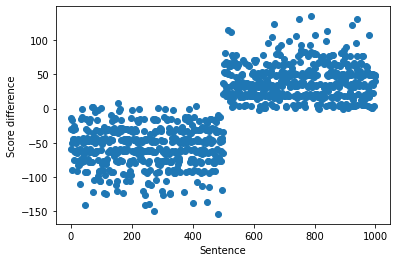

In [8]:
# calcualtes score difference between log probabality of Trump and Obama
state['score_diff'] = state['log_probability_trump'] - state['log_probability_obama']
# creates a scatter plot of each score difference 
mat.scatter(state['id'], state['score_diff'])
mat.xlabel('Sentence')
mat.ylabel('Score difference')
# displays the plot 
mat.show()

In [14]:
#part c:
def words_lists(words, unique_word, amount_used=False):
    # sort the word list and remove duplicates
    unique_word = sorted(list(set(unique_word)))
    if amount_used:
        # if amount_used is True, count the amount of each word in the input list
        count = Counter(words)
        # return a list of frequency counts for each word in the word list
        return [count[w] for w in unique_word]
    else:
        # if amount_used is False, return a list of 1s and 0s indicating whether each word in the word list is present in the input list
        return [int(w in words) for w in unique_word]
def the_distance(sena, senb):
    # Convert the sentences to vectors using the  function
    vectora = words_lists(sena, topmost_word['word'])
    vectorb = words_lists(senb, topmost_word['word'])
    # Calculate the distance between the two vectors
    dist = np.linalg.norm(np.array(vectora) - np.array(vectorb))
    return dist
def knn(sen, k, train_set):
    # Calculate the distance between the input sentence and all sentences in the training set
    train_set['distance'] = train_set['text'].apply(lambda x: the_distance(sen, x))
    # Sort the training set by distance and take the top k nearest neighbors
    sorting = train_set.sort_values(by='distance', ascending=True)
    knn_value = sorting.head(k)
    # Calculate the probabilities of the sentence being spoken by Trump and Obama based on the k nearest neighbors
    probability_trump = len(knn_value[knn_value['speaker'] == 'trump']) / k
    probability_obama = len(knn_value[knn_value['speaker'] == 'obama']) / k
    # If the probability of Trump is higher, return 1. Otherwise, return 0.
    if probability_trump > probability_obama:
        return '1'
    else:
        return '0'
def validation(n, k):
    # Divide the data into n folds for cross-validation
    n_fold = int(len(state2) / n)
    metric_knn = pd.DataFrame(columns=['accuracy', 'sensitivity', 'specificity', 'precision', 'f1'])

    for i in range(n):
        # Take one fold as the test set and the rest as the training set
        train_set = pd.concat([state2.iloc[:i * n_fold], state2.iloc[(i + 1) * n_fold:]]).reset_index(drop=True)
        state_test = state2.iloc[i * n_fold:(i + 1) * n_fold].reset_index(drop=True)
        # Apply the knn function to each sentence in the test set to get a prediction
        state_test['prediction'] = state_test['text'].apply(lambda x: knn(x, k, train_set))
        # Calculate various metrics to evaluate the performance of the classifier
        accuracy, sensitivity, specificity, precision, f1 = stats_of_classifier(state_test, probability_before, word_probabality)
        # Store the metrics in a dataframe
        metric_knn.loc[i] = [accuracy, sensitivity, specificity, precision, f1]
    # Calculate the mean of the metrics across all folds and add to the dataframe
    metric_knn.loc['mean'] = metric_knn.mean()
    return metric_knn

In [15]:
# create a copy of the original 'state' dataframe
state2 = state.copy()
# remove the 'prediction' column from the copied dataframe
state2.drop(columns=['prediction'])     
# create a list of the top 1000 words from the 'count_of_word' dataframe, 
#sorted by the absolute value of their 'phi' column
set_of_words= list(count_of_word['phi'].abs().sort_values(ascending=False).head(1000).index)
# create a new dataframe containing the top 1000 words from 'count_of_word', sorted by their frequency count
topmost_word = count_of_word.loc[count_of_word.index.isin(set_of_words)].sort_values(by='count', ascending=False).reset_index(drop=True) 
print(topmost_word)
# shuffle the rows in the 'state2' dataframe
state2 = state2.sample(frac=1).reset_index(drop=True)  
# create a new column in the 'state2' dataframe called 'vector', 
#which contains the word vectors of each sentence in 'state2'
state2['vector'] = state2['text'].apply(lambda x: words_lists(x, topmost_word['word']))    
print(state2)
# create an empty list to store the accuracy scores for each value of k
list_accuracy = [] 
# iterate over values of k from 1 to 31 in steps of 2
for k in range(1, 32, 2):
    # perform 10-fold cross-validation on 'state2' with a value of k
    metric_knn = validation(10, k) 
    # append the mean accuracy score for this value of k to the 'list_accuracy'
    list_accuracy.append(metric_knn['accuracy']['mean'])
    # print the results of cross-validation for this value of k
    print(metric_knn) 


          word  count  obama_count  obama_sentence_count  trump_count  \
0        going    114         15.0                    15         99.0   
1       people    107         43.0                    44         64.0   
2         know     72         16.0                    22         56.0   
3         said     58         12.0                    10         46.0   
4        thats     48         24.0                    23         24.0   
..         ...    ...          ...                   ...          ...   
546  supported      2          1.0                     1          1.0   
547   everyday      2          1.0                     1          1.0   
548       sent      2          1.0                     3          1.0   
549     insist      2          1.0                     2          1.0   
550     safety      2          1.0                     1          1.0   

     trump_sentence_count       phi  
0                      81  0.264308  
1                      61  0.067936  
2        

NameError: name 'word_probabality' is not defined

In [ ]:
# This line creates a line plot of the values in the list 'list_accuracy'
# against the values generated by the range function (1, 3, ..., 31).
# The x-axis will be labeled with these values, and the y-axis will
# be labeled with the values in 'list_accuracy'.
mat.plot(range(1, 32, 2), list_accuracy)
# This line sets the label for the x-axis of the plot.
mat.xlabel('k')
# This line sets the label for the y-axis of the plot.
mat.ylabel('Accuracy')
# This line displays the plot.
mat.show()